# C4 metacalibration on cluster injections


In this notebook we will finally connect the dots, and apply the metacalibration algorithm to estimate the shear field around a galaxy cluster injected into the DC2 simulation.

## Objectives

    1 Use the metacalibration algorithm in the cluster lensing scenario

    2 Measure the tangential shear field induced by a galaxy cluster
   

## Setup

This notebook relies on the:

    * synthetic package & dependencies
    
    * DC2 cutotut data files on disk
    
    * curated galaxy cluster member catalog (see A4 notebook)
       


## Output

    * tangential shear profile input vs measured for a galaxy cluster
    
    
The output files are placed in the `./data/` folder


## Contact

In case of questions, contact me at t.varga@physik.lmu.de

In [24]:
import fitsio as fio
import numpy as np
import pandas as pd
import pickle as pickle
import copy
import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.cosmology as cosmology

import images # package from erin sheldon

import synthetic.tools as tools
import synthetic.render.frame as frame
import synthetic.render.render as render
import synthetic.render.icl as icl

import galsim
import images # package from erin sheldon

import meds
import psfex # The python wrapper

pixel_scale = 0.2

# Prepare the cluster injection

In [4]:
# File path for input DC2 files
in_path = "/e/ocean1/users/vargatn/LSST/DC2_1.1.4/" 
# output path for mock image, be sure to place it into 
out_path = "data/"

In [11]:
table_path = '/e/ocean1/users/vargatn/LSST/SYNTHETIC/curated_table.h5'
table = pd.read_hdf(table_path, key="data")

ra_cen = 50.64516228577292
dec_cen = -40.228830895890404

mock_catalog_path = '/e/ocean1/users/vargatn/LSST/SYNTHETIC/curated_mock_catalog.h5'
mock_catalog = pd.read_hdf(mock_catalog_path, key="data")

## Create a shear profile

For illustration purposes, we are going to use an isothermal (power law) shear profile

In case you have other preferences, the below section is where you must modify the line-of-sight catalog

You can add magnification, or other shear profiles as your preferences dictate

In [12]:
cosmo = cosmology.FlatLambdaCDM(Om0=0.3, H0=70)

In [13]:
image_offset=(2499.5, 2499.5)

xra = (mock_catalog['X'] - image_offset[0]) * pixel_scale / 60 # arcmin
ydec = (mock_catalog['Y'] - image_offset[1]) * pixel_scale / 60 # arcmin
dists = np.sqrt(xra**2 + ydec**2)

shears = np.sqrt(1 / dists  / 400) # just for illustration purposes
shears[shears > 0.8] = 0.8 # galsim cannot render very large shears properly

phis =  np.arctan2(ydec, xra)
es1 = (-1. * shears * np.cos(2 * phis))
es2 = (-1. * shears * np.sin(2 * phis))


e1 = mock_catalog['G1']
e2 = mock_catalog['G2']
vals1 = e1 + es1 - e1 * es1 - e2 * es2 # Calculate the sheared galaxy shape
vals2 = e2 + es2 - es1 * e2 + es2 * e1

tmp = np.sqrt(vals1**2. + vals2**2.)
ii = tmp > 0.9 # galsim cannot render very large shears properly, we must reduce the 
divs = 1. / (0.1 + tmp[ii])  
vals1[ii] *= divs
vals2[ii] *= divs

# Add shear only to galaxies, which are at z > 0.4,
# this is a super simple approximation, intended to showcase the functionality
jj = table['redshift_true'] > 0.4

mock_catalog.loc[jj, "G1"] = vals1[jj]
mock_catalog.loc[jj, "G2"] = vals2[jj]

## Render cluster injection

For this example, we are going to use a curated galaxy cluster member catalog

In [14]:
mock_cluster_path = '/e/ocean1/users/vargatn/LSST/SYNTHETIC/curated_cluster_model_v01-z0l0_15000_001.h5'
mock_cluster = pd.read_hdf(mock_cluster_path, key="data")

For this example, this is saved in the same database format (exact same columns) as the DC2 catalog which we used above, so we can simply concatenate them in pandas

In [15]:
mock_all = pd.concat((mock_cluster, mock_catalog))

In [16]:
# These are the approcimate noise levels we are going to use for mock images in this notebook
# g, r, i, z bands
stds = np.array([2.509813, 5.192254, 8.36335, 15.220351]) / 1.3

# This is the file name root, appended by bands
# we render only g, r, i as those already make a nice color image
file_name_tag = 'test_cluster_canvas_dc2_' #

for i, band in enumerate(("g", "r", "i")):
    name = out_path + file_name_tag + band
    print(name)
    fr = frame.Frame(mock_all.to_records(), band=band, name=name,
                     center=(ra_cen, dec_cen), noise_std=stds[i], canvas_size=5000)
    fr.render() 

data/test_cluster_canvas_dc2_g
starting postage stamp calculations in 100 processes
data/test_cluster_canvas_dc2_r
starting postage stamp calculations in 100 processes
data/test_cluster_canvas_dc2_i
starting postage stamp calculations in 100 processes


## Create intra-cluster-light image

We are creating the ICL as a separate 2D array, for each pixel of the observation canvas. So that it can be manipulated as an image, added directly to the rendered galaxy catalogs. 

This way an arbitrary light profile can be added. In the following we are going to use the approach and codebase derived from Varga et al 2021, based on the parametrization of Gruen et al 2019, using the intra cluster light measurements of Zhang et al 2019.

In this approach, a doughnut shaped pseudo ICL model is calculated, which is the real ICL light profile from which the core Elliptical galaxy is subtracted out, so that the sum of the two components will agree with the observed light distribution.

We should note that the ICL can have an ellipticity in this model, for now simply taken as the orientation of the BCG.

In [17]:
galpath = "../notebooks/galsim/ICL/evolving_red_gal.dat"
mstarpath = "../notebooks/galsim/ICL/mstar_des_i03.fit"
jk_profile_root = "../notebooks/galsim/ICL/jacknife_profiles_0.15_rand_back_subtracted_corZ_faintgalsub/jacknife_profile_"

bcg = {
    "size": 32.,
    "g1": -0.1356766444194723,
    "g2":0.0345231539560347,
    "imag": 17.76, # i band magnitude
    "color_gr": 1.36,
    "color_ri": 0.54,
    "color_iz": 0.32,
}
mass = 10**14.45 # in solar masses
z = 0.3 # cluster redshift


In [18]:
di = icl.DrawICL(mass, z, bcg, galpath, mstarpath, jk_profile_root)
di.get_icl()
ims_icl = [di.flux_g, di.flux_r, di.flux_i, di.flux_z]

/home/moon/vargatn/DES/SYNTHETIC/synthetic/synthetic/render/icl.py:21: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((arr - pos) * k))


then we load the pre icl images:

In [19]:
ims_all = []
for i, band in enumerate(("g", "r", "i")):
    name = out_path + 'test_cluster_canvas_dc2_' + band + ".fits"
    tmp = fio.read(name)
    print(name)
    ims_all.append(tmp)

data/test_cluster_canvas_dc2_g.fits
data/test_cluster_canvas_dc2_r.fits
data/test_cluster_canvas_dc2_i.fits


So that we can simply add the two components together

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.8697633743286133


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.8698196411132812


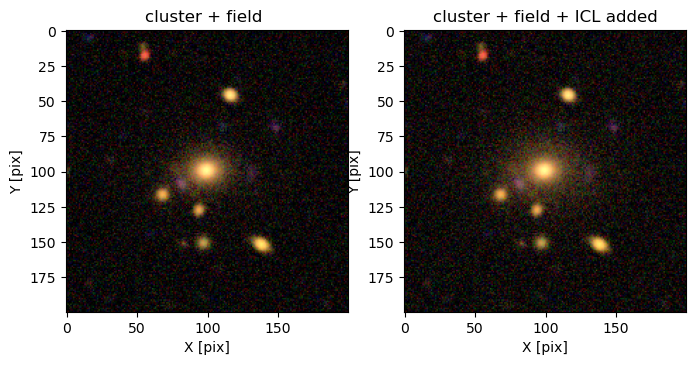

In [20]:
fig, axarr = plt.subplots(ncols=2, figsize=(8, 4))

ax = axarr[0]
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(ims_all[2] + pad,
                                ims_all[1] + pad,
                                ims_all[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im[2400:2600, 2400:2600] * 2, origin='upper')

ax.set_title("cluster + field ")

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")

ax = axarr[1]
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(ims_all[2] + ims_icl[2] + pad,
                                ims_all[1] + ims_icl[1] + pad,
                                ims_all[0] + ims_icl[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im[2400:2600, 2400:2600] * 2, origin='upper')

ax.set_title("cluster + field + ICL added")

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")

fig.savefig("data/dc2_hp_icl_panel.png", bbox_inches='tight')

## Creating a deeper, detection image and weight map

source detection is traditionally done on coadded images, even when shear estimation is performed per-frame for greater performance.

For this reason, unlike in B1, B2, B3, we are going to create a single, deeper, detection frame

In [22]:
band = 'i'
name = out_path + 'test_canvas_' + band
print(name)
fr = frame.Frame(mock_catalog.to_records(), band=band, name=name,
                     center=(ra_cen, dec_cen), noise_std=1., canvas_size=5000, config_se='data/configs/config.sex')
fr.render() 

data/test_canvas_i
starting postage stamp calculations in 100 processes


In [25]:
noise = np.ones(shape=(fr.canvas_size, fr.canvas_size)) # this is set as 1, as in this example that's the noise std
wcanvas = galsim.ImageF(noise, wcs=fr.canvas.wcs)
wcanvas.write(name + '_weight.fits', clobber=True)

In [ ]:
fr.extract()